In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import numpy as np # linear algebra
from scipy.stats import uniform
from scipy.sparse import csr_matrix

%matplotlib inline

In [61]:
# Import the data
tweet_df = pd.read_csv("clean_preprocessed.csv")
tweet_df.columns
tweet_df = tweet_df.rename(columns={'preproc_text':'clean_text'})
cleanTweet = tweet_df.copy()[["clean_text","polarity"]]

In [62]:
# Define the sentiment carrying in the text
def text_category(tweet_polarity):
    '''A function to return the sentiment carried by a tweet text'''
    if tweet_polarity>0:
        return "positive"
    elif tweet_polarity<0:
        return "negative"
    else:
        return "neutral"

In [63]:
cleanTweet["score"] = cleanTweet["polarity"].apply(text_category)
score_sent = cleanTweet["score"].value_counts()
score_sent

neutral     6932
positive    5722
negative    2428
Name: score, dtype: int64

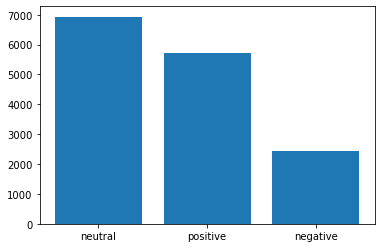

In [64]:
plt.bar(score_sent.index,score_sent.values)
plt.show()

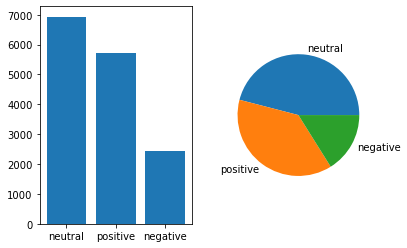

In [65]:
fig,ax = plt.subplots(1,2)
ax[0].bar(score_sent.index,score_sent.values)
ax[1].pie(score_sent,labels=['neutral','positive','negative'])
plt.show()

In [66]:
# Extract the positive and negative
cleanTweet = cleanTweet[cleanTweet["score"]!="neutral"]
cleanTweet["score"].value_counts()

positive    5722
negative    2428
Name: score, dtype: int64

In [67]:
# Re-index the frame
cleanTweet = cleanTweet.reset_index(drop=True)
cleanTweet

,clean_text,polarity,score
0,rt @northstarcharts: the -year yield is tellin...,0.160000,positive
1,rt @michaelaarouet: german y mortgage rate wen...,0.150000,positive
2,rt @biancoresearch: rates rise until something...,-0.400000,negative
3,rt @lanceroberts: buying opportunities like th...,-0.100000,negative
4,rt @macroalf: welcome to september .\n\nbond m...,0.400000,positive
...,...,...,...
8145,"rt @ferozkhaninc: in #telangana rapes, murders...",0.095455,positive
8146,"rt @ozamizcps: pssg gedson castañeros, mobile ...",0.100000,positive
8147,rt @salt_project_os: free yourself from writin...,0.400000,positive
8148,rt @pbhushan: thank you @bajpayeemanoj for thi...,0.850000,positive


In [68]:
# Create a function to encode the sentiment
def encode_sentiment(sentiment):
    '''Encode the sentiment. 1 if positive, 0 otherwise'''
    if sentiment=="positive":
        return 1
    else: return 0

In [141]:
cleanTweet['scoremap'] = cleanTweet['score'].apply(encode_sentiment)
cleanTweet['scoremap'].describe()

count    8150.000000
mean        0.702086
std         0.457370
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: scoremap, dtype: float64

In [142]:
# Create features and target variable
(X,y) = (cleanTweet['clean_text'],cleanTweet['scoremap'])

In [161]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

In [172]:
# Create the trigram vectorize
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_vectorizer.fit(X_train.values)

CountVectorizer(ngram_range=(3, 3))

In [173]:
trigram_vectorizer.vocabulary_

{'whyteleafeeagle sorry but': 84054,
 'sorry but he': 65769,
 'but he going': 11106,
 'he going to': 29315,
 'going to trip': 26705,
 'to trip himself': 77340,
 'trip himself up': 78555,
 'himself up should': 30246,
 'up should have': 79918,
 'should have used': 64349,
 'have used an': 29127,
 'used an extendable': 80341,
 'an extendable lead': 2943,
 'leftists anti police': 39567,
 'anti police policies': 4698,
 'police policies have': 54779,
 'policies have led': 54792,
 'have led to': 28940,
 'led to startling': 39514,
 'to startling number': 77055,
 'startling number of': 66531,
 'number of black': 48390,
 'of black latino': 48720,
 'black latino crime': 9670,
 'latino crime victims': 39147,
 'crime victims co': 15922,
 'victims co kwbkkyvlw': 80906,
 'oregongovbrown lamresearch adi_news': 51970,
 'lamresearch adi_news these': 38859,
 'adi_news these corporations': 828,
 'these corporations are': 73601,
 'corporations are going': 15298,
 'are going to': 5312,
 'going to require': 2

In [174]:
df = pd.DataFrame(trigram_vectorizer.vocabulary_.items(),columns=['Vocabulary','Frequency'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87759 entries, 0 to 87758
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Vocabulary  87759 non-null  object
 1   Frequency   87759 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [175]:
df = df.sort_values(by='Frequency',ascending=False)

In [176]:
df.head(20)

,Vocabulary,Frequency
44896,𝘄𝗼𝗿𝗹𝗱 𝗵𝗮𝘀 𝗰𝗵𝗮𝗻𝗴𝗲𝗱,87758
44894,𝘄𝗵𝗶𝗰𝗵 𝘁𝗵𝗲 𝘄𝗼𝗿𝗹𝗱,87757
44892,𝘄𝗮𝘆𝘀 𝗶𝗻 𝘄𝗵𝗶𝗰𝗵,87756
44895,𝘁𝗵𝗲 𝘄𝗼𝗿𝗹𝗱 𝗵𝗮𝘀,87755
51628,𝗿𝗲𝗮𝗱𝘆 mm_footballclub mufc,87754
44893,𝗶𝗻 𝘄𝗵𝗶𝗰𝗵 𝘁𝗵𝗲,87753
44890,𝗦𝗵𝗶𝗳𝘁 𝗙𝗶𝘃𝗲 𝘄𝗮𝘆𝘀,87752
44889,𝗚𝗹𝗼𝗯𝗮𝗹 𝗦𝗵𝗶𝗳𝘁 𝗙𝗶𝘃𝗲,87751
44891,𝗙𝗶𝘃𝗲 𝘄𝗮𝘆𝘀 𝗶𝗻,87750
1960,유진 ive 아이브,87749


In [177]:
df.tail(20)

,Vocabulary,Frequency
34760,_idontcomply_ horley surrey,19
44126,_idontcomply_ exactly my,18
79157,_fels just because,17
26259,_fathima_usmaan mr bcnagesh_bjp,16
35162,_denisepaul lizzydobres sarmila_v,15
17466,_deepphilosophy deep philosophy,14
34290,_crymiariver we don,13
75482,_colt_blooded_ no_pullbacks oh,12
33000,_cingraham reality is,11
45322,_cingraham it always,10


In [178]:
X_train_trigram = trigram_vectorizer.transform(X_train.values)

Trigram Tf-Idf

In [179]:
trigram_tf_idf_transformer = TfidfTransformer()
trigram_tf_idf_transformer.fit(X_train_trigram)
X_train_trigram_tf_idf = trigram_tf_idf_transformer.transform(X_train_trigram)

SGD Classifier

In [180]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [181]:
train_and_show_scores(X_train_trigram, y_train.values, 'Trigram Counts')
train_and_show_scores(X_train_trigram_tf_idf, y_train.values, 'Trigram Tf-Idf')

Trigram Counts
Train score: 1.0 ; Validation score: 0.72

Trigram Tf-Idf
Train score: 1.0 ; Validation score: 0.72

